In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

# 학습용 데이터 만들기

In [ ]:
# 학습데이터 정제
# 임의의 프레임 추출코드 - 항목마다 전체 이미지 갯수가 다르다
base_dir = '../data/pre'
folder_list = os.listdir(base_dir)

batch_size = 1
batch_x_data = list()
batch_t_data = list()

frame_num = 20

for folder in folder_list[0:1*batch_size]:
    for n in range(10):
        file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
        temp_data = list()
        for i in range(frame_num):
            img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(i*(len(file_list)/frame_num)))+'.jpg')))
            img = img.resize(size=(112, 112))
            img = np.array(img)
            img = img.reshape(112,112,3)
            temp_data.append(img)
        temp_data = np.array(temp_data)
        batch_x_data.append(temp_data)
        batch_t_data.append(n)

In [ ]:
# 리스트인 batch_x_data를 ndarray로
batch_x_data = np.array(batch_x_data)
print(batch_x_data.shape)

In [ ]:
# 축변경
batch_x_data = np.swapaxes(batch_x_data,1,2)
batch_x_data = np.swapaxes(batch_x_data,2,3)

print(batch_x_data.shape)

In [ ]:
# one_hot_encording
batch_t_data = np.array(batch_t_data)
batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
display(batch_t_data)
batch_t_data = pd.get_dummies(batch_t_data['t'])
display(batch_t_data)

In [ ]:
# 데이터 확인
figure = plt.figure(figsize=(10,10))

fig_list=list()
for i in range(20):
    fig_list.append(figure.add_subplot(5,4,i+1))
    test = batch_x_data[0,:,:,i,:]
    fig_list[i].imshow(test.reshape(112,112,3))

# 모델

In [2]:
# GPU 메모리제한
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*7)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [8]:
# 모델 작성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv3D, MaxPool3D,Flatten, Activation, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2

weight_decay = 0.005
frame_num = 20

model = Sequential()
model.add(Conv3D(64,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=(112,112,frame_num,3)))
model.add(MaxPool3D((2,2,1),strides=(2,2,1),padding='same'))

model.add(Conv3D(128,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(256,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(256,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Flatten())
model.add(Dense(units=int(4096/2), activation='relu'))
model.add(Dense(units=int(4096/2), activation='relu'))

model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 112, 112, 20, 64)  5248      
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 56, 56, 20, 64)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 56, 56, 20, 128)   221312    
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 28, 28, 10, 128)   0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 28, 28, 10, 256)   884992    
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 28, 28, 10, 256)   1769728   
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 14, 14, 5, 256)   

In [9]:
# 학습데이터 정제
# 임의의 프레임 추출코드 - 항목마다 전체 이미지 갯수가 다르다
base_dir = '../data/pre'
folder_list = os.listdir(base_dir)

batch_size = 3
shuffle_list = list(range(0,10))*batch_size

for batch in range(int(42/batch_size)):
    batch_x_data = list()
    batch_t_data = list()
    for folder in folder_list[batch*batch_size:(batch+1)*batch_size]:
        for n in range(10):
            file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
            temp_data = list()
            for i in range(frame_num):
                img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(i*(len(file_list)/frame_num)))+'.jpg')))
                img = img.resize(size=(112, 112))
                img = np.array(img)
                temp_data.append(img)
            temp_data = np.array(temp_data)
            batch_x_data.append(temp_data)
            batch_t_data.append(n)

    # 리스트인 batch_x_data를 ndarray로
    batch_x_data = np.array(batch_x_data)
    batch_t_data = np.array(batch_t_data)
    
    # 축변경
    batch_x_data = np.swapaxes(batch_x_data,1,2)
    batch_x_data = np.swapaxes(batch_x_data,2,3)
    
    # data shuffle
    random.shuffle(shuffle_list)
    
    batch_x_data = batch_x_data[shuffle_list]
    batch_t_data = batch_t_data[shuffle_list]

    # one_hot_encording
    batch_t_data = np.array(batch_t_data)
    batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
    batch_t_data = pd.get_dummies(batch_t_data['t'])
    
    # learning
    history = model.fit(x=batch_x_data, y=batch_t_data, epochs=10, verbose=1)

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[30,64,112,112,20] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_2/conv3d_16/Conv3D (defined at <ipython-input-9-a1eab339a990>:45) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_6272]

Function call stack:
train_function


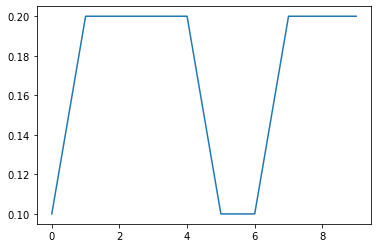

In [5]:
plt.plot(history.history['accuracy'])
plt.show()

In [6]:
result = model.evaluate(x=batch_x_data, y=batch_t_data)
print(result)

1/1 [==============================] - 0s 977us/step - loss: 7.9246 - accuracy: 0.1000
[7.924627304077148, 0.10000000149011612]
